In [ ]:
#Code to be run ONCE, when the enviroment is first started. Takes ~4-5 min. to run
#Command line arguments to PROPERLY install PyTorch
!pip install torch==2.1.0
!pip install torchaudio==2.1.0
!pip install torchvision==0.16.0
!pip install torchtext==0.16.0
!pip install pillow

#Get the data into CoLab
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
!mkdir data
!unzip new-york-city-airbnb-open-data.zip -d data

#Standard library imports



import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
import torchtext.data.utils
import torchtext.vocab
import os
import torchvision
import PIL
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from collections import Counter, OrderedDict
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

Saving new-york-city-airbnb-open-data-metadata(1).json to new-york-city-airbnb-open-data-metadata(1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data
License(s): CC0-1.0
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 132MB/s]
Archive:  new-york-city-airbnb-open-data.zip
  inflating: data/AB_NYC_2019.csv    
  inflating: data/New_York_City_.png  


# **PLAN OF ACTION**
- Clean dataset (Done)
- Run 5 decision tree regressions, each more complex than the last (Complexity = tree depth)
  - Call this "Experiment 1"
- Run 5 Multilayer Perceptron regressions, each with more neurons than the last (Complexity = num neuron layers)
  - This is "Experiment 2", and it disproves Occam's razor
- Document success stats for each regression run (Maybe Loss & AUC?)

- ***Presentation Notes:***
  - Normalize the complexity metrics into real numbers between 0 and 1
  - Chart all families of regressions on the same graph, each family a different color line (Complexity on X axis, success score on Y)
  - Note that we're using non-parametric models, meaning WE decide wht complexity is
  - ???
  - Conclude that Occam's Razor cannot be epistemically proven because the metric of complexity is too arbitrary
  - Fill in the presentation's time gaps with info about PAC learning and VC dimentions



In [ ]:
#Part 1: Clean Dataset
#Code generated by ChatGPT using the following prompt:
  #Please create code to clean the dataset located at
  #https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data and
  #starting with this line of code:

  #df = pd.read_csv(filepath_or_buffer='/content/data/AB_NYC_2019.csv', on_bad_lines='skip')

  #The goal is to have one continuous target variable named price, and to feed this clean data
  #into a pytorch linear regression. The feature data should be split into X_tr and X_te, and the
  #target data split into Y_tr and Y_te. Additionally, please make sure the dataset is all the same
  #data type to alleviate tensor conversion errors

#Chat's response:

# Step 1: Load the dataset
df = pd.read_csv(filepath_or_buffer='/content/data/AB_NYC_2019.csv', on_bad_lines='skip')

# Step 2: Inspect the data for any missing or problematic values
print(df.info())  # Check data types and missing values
print(df.describe())  # Get summary statistics to identify outliers or anomalies

# Step 3: Drop columns that are irrelevant to the model
# For example, removing text-based columns such as 'name', 'host_name', 'last_review'
df = df.drop(columns=['name', 'host_name', 'last_review'])

# Step 4: Handle missing values
# Human intervention: Chat wants to fill all NaN values with the mean, but I'm gonna drop them
df = df.dropna()

# Step 5: Convert categorical variables into numerical values using one-hot encoding
# Let's apply one-hot encoding for categorical columns like 'neighbourhood_group', 'neighbourhood', and 'room_type'
df = pd.get_dummies(df, drop_first=True)

# Step 6: Ensure all columns have appropriate data types (float or int)
df = df.astype(np.float32)

# Step 7: Define the target variable and feature set
X = df.drop(columns=['price'])  # Features
y = df['price']  # Target variable (price)

# Step 8: Normalize the feature data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 9: Split the data into training and test sets
X_tr, X_te, Y_tr, Y_te = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 10: Convert the data to PyTorch tensors
#Human intervention: Just some stylizing
X_tr = torch.tensor(X_tr, dtype=torch.float32)
X_te = torch.tensor(X_te, dtype=torch.float32)
Y_tr = torch.tensor(Y_tr.values, dtype=torch.float32).view(-1, 1)  # Reshape for regression
Y_te = torch.tensor(Y_te.values, dtype=torch.float32).view(-1, 1)

# Define dataset and dataloaders
#Human intervention: Moved this in from another segment
train_dataset = TensorDataset(X_tr, Y_tr)
test_dataset = TensorDataset(X_te, Y_te)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
#Part 2.1: Decision Tree Definition

#Code generated by ChatGPT using the following prompt:
#Assuming that Y_tr is one continuous target feature and X_tr
#contains 232 features, create a simple linear regression with pytorch
#that uses the entire dataset
from sklearn import tree

# Step 3: Create and train the Decision Tree model
def train_decision_tree(dataloader, max_depth=16):
    # Initialize the DecisionTreeRegressor model
    model = DecisionTreeRegressor(max_depth=max_depth)

    # For simplicity, we'll train the model using the entire dataset (ignoring batches for now)
    X_full = X_tr
    y_full = Y_tr

    # Convert to numpy arrays for scikit-learn compatibility
    X_full = X_full.numpy()
    y_full = y_full.numpy()

    # Fit the model
    model.fit(X_full, y_full)

    return model

# Step 4: Evaluate the model
def evaluate_model(model, X_test, y_test):
    # Ensure test data is in numpy format
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.numpy()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

# Step 5: Set parameters and train
max_depth = 5  # Example adjustable depth
model = train_decision_tree(train_loader, max_depth=max_depth)

# Step 6: Evaluate the model (Assuming you have X_test and Y_test)
mse, y_pred = evaluate_model(model, X_te, Y_te)
#tree.plot_tree(model)

# Calculate R-squared
r2 = abs(r2_score(Y_te.numpy(), y_pred))  # Ensure Y_te is a numpy array
print(f'Mean Squared Error on Test Data: {mse}')
print(f'R-squared Coefficient: {r2}')



"""ENDING DATA
DEPTH ::          R2         ::     MSE
2     :: 0.14239199126043334 :: 24677.24551073914
4     :: 0.13915859122635543 :: 24770.284994585196
8     :: 0.14239199126043334 :: 24677.24551073914
16    :: 0.026224523862145466:: 29529.10218469975
32    :: 0.14239199126043334 :: 24677.24551073914
"""

Mean Squared Error on Test Data: 29436.062700853694
R-squared Coefficient: 0.02299112382806756


'ENDING DATA\nDEPTH ::          R2         ::     MSE\n2     :: 0.14239199126043334 :: 24677.24551073914\n4     :: 0.13915859122635543 :: 24770.284994585196\n8     :: 0.14239199126043334 :: 24677.24551073914\n16    :: 0.026224523862145466:: 29529.10218469975\n32    :: 0.14239199126043334 :: 24677.24551073914\n'

In [ ]:
#Part 2.2: MLP Definition

#Code generated by ChatGPT using the following prompt:
#Assuming that Y_tr is one continuous target feature and X_tr
#contains 232 features, create a simple Multilayer Perceptron with pytorch
#that uses dataloaders


# Define the MLP model
class MLPRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(MLPRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim2, 1)  # Output layer for continuous target
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # First layer with ReLU activation
        x = self.relu(self.fc2(x))  # Second layer with ReLU activation
        x = self.fc3(x)  # Output layer (no activation for regression)
        return x

# Training function using DataLoader
def train_mlp_regression(train_loader, input_dim, num_epochs=100, lr=0.01, hidden_dim1=32, hidden_dim2=16):
    model = MLPRegressionModel(input_dim, hidden_dim1, hidden_dim2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = criterion(outputs, Y_batch)
            loss.backward()

            # Update parameters
            optimizer.step()
            epoch_loss += loss.item()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')

    return model

# Training the MLP model
input_dim = X_tr.shape[1]
model = train_mlp_regression(train_loader, input_dim)

# Evaluation on test set
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            preds = model(X_batch)
            predictions.append(preds)
    return torch.cat(predictions, dim=0)

# Get predictions on the test set
Y_pred = evaluate_model(model, test_loader)
#print("Predictions:", Y_pred)

from sklearn.metrics import r2_score

r2 = r2_score(Y_te, Y_pred)
mse = mean_squared_error(Y_te, Y_pred)
print(f'Mean Squared Error on Test Data: {mse}')
print(f'R-squared Coefficient: {r2}')


Epoch 0/100, Loss: 37483.59058646999
Epoch 10/100, Loss: 35229.821423628695
Epoch 20/100, Loss: 34045.92818152659
Epoch 30/100, Loss: 30126.487461419754
Epoch 40/100, Loss: 27507.346948631508
Epoch 50/100, Loss: 26347.375124425063
Epoch 60/100, Loss: 24530.932698567707
Epoch 70/100, Loss: 24516.731839215314
Epoch 80/100, Loss: 25030.223041738504
Epoch 90/100, Loss: 24216.654348742322
Mean Squared Error on Test Data: 32943.703125
R-squared Coefficient: -0.14489202671247736


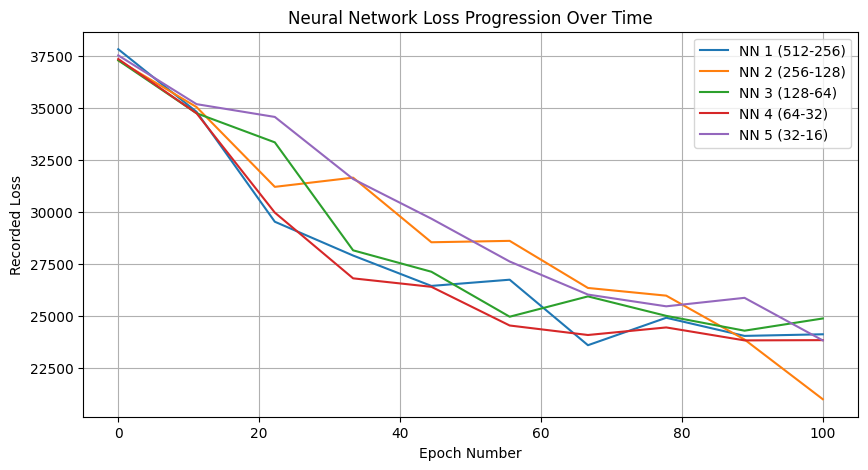

'IMAGE 5 512-256\nEpoch 0/100, Loss: 37831.49134512693\nEpoch 10/100, Loss: 34817.4407488976\nEpoch 20/100, Loss: 29525.669396608453\nEpoch 30/100, Loss: 27898.09779103597\nEpoch 40/100, Loss: 26435.910510467405\nEpoch 50/100, Loss: 26734.862482141565\nEpoch 60/100, Loss: 23580.949633186247\nEpoch 70/100, Loss: 24902.587141798358\nEpoch 80/100, Loss: 24029.207499060612\nEpoch 90/100, Loss: 24107.267543588645\nMean Squared Error on Test Data: 24443.767578125\nR-squared Coefficient: 0.15050603620997416\n'

In [ ]:
#Part 3.1: Loss Over Time Graphing

NN_Outs = [
  [37831.491,
   34817.440,
   29525.669,
   27898.097,
   26435.910,
   26734.862,
   23580.949,
   24902.587,
   24029.207,
   24107.267],
  [37295.525,
   35047.202,
   31205.044,
   31647.890,
   28537.827,
   28604.844,
   26337.122,
   25966.878,
   23855.058,
   20980.481],
  [37296.247,
   34749.310,
   33347.662,
   28148.916,
   27118.250,
   24952.712,
   25931.601,
   24994.020,
   24280.074,
   24868.293],
  [37361.069,
   34749.310,
   29965.451,
   26800.277,
   26392.101,
   24529.805,
   24072.490,
   24436.511,
   23812.920,
   23825.358],
  [37534.983,
   35187.028,
   34571.320,
   31582.291,
   29672.692,
   27610.776,
   26018.694,
   25453.712,
   25861.912,
   23811.711]
]





# Create the Loss Plot
plt.figure(figsize=(10, 5))
x = np.linspace(0, 100, num=10)  # X-axis values

# Plot each line
plt.plot(x, NN_Outs[0], label="NN 1 (512-256)")
plt.plot(x, NN_Outs[1], label="NN 2 (256-128)")
plt.plot(x, NN_Outs[2], label="NN 3 (128-64)")
plt.plot(x, NN_Outs[3], label="NN 4 (64-32)")
plt.plot(x, NN_Outs[4], label="NN 5 (32-16)")

#ALSO plot the MSE per run on another graph, and R2 per run on yet another

# Add labels, title, and legend
plt.xlabel('Epoch Number')
plt.ylabel('Recorded Loss')
plt.title('Neural Network Loss Progression Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()







"""IMAGE 2, 64-32
Epoch 0/100, Loss: 37361.06932589056
Epoch 10/100, Loss: 34749.31068728098
Epoch 20/100, Loss: 29965.451364211094
Epoch 30/100, Loss: 26800.277741985556
Epoch 40/100, Loss: 26392.101230762622
Epoch 50/100, Loss: 24529.805345072178
Epoch 60/100, Loss: 24072.490350260166
Epoch 70/100, Loss: 24436.511518643227
Epoch 80/100, Loss: 23812.92018749096
Epoch 90/100, Loss: 23825.358592845776
Mean Squared Error on Test Data: 24295.44921875
R-squared Coefficient: 0.15566052245301976
"""

"""IMAGE 3, 32-16
Epoch 0/100, Loss: 37534.98383168036
Epoch 10/100, Loss: 35187.02812389484
Epoch 20/100, Loss: 34571.32099960076
Epoch 30/100, Loss: 31582.291502273623
Epoch 40/100, Loss: 29672.692474993168
Epoch 50/100, Loss: 27610.776549853414
Epoch 60/100, Loss: 26018.694035910776
Epoch 70/100, Loss: 25453.712891064555
Epoch 80/100, Loss: 25861.91267096751
Epoch 90/100, Loss: 23811.71184436186
Mean Squared Error on Test Data: 32943.703125
R-squared Coefficient: -0.14489202671247736
"""

"""IMAGE 4 256-128
Epoch 0/100, Loss: 37295.525941385655
Epoch 10/100, Loss: 35047.202030009204
Epoch 20/100, Loss: 31205.044337143132
Epoch 30/100, Loss: 31647.890213703424
Epoch 40/100, Loss: 28537.827000056765
Epoch 50/100, Loss: 28604.84443633154
Epoch 60/100, Loss: 26337.122091976213
Epoch 70/100, Loss: 25966.878146764182
Epoch 80/100, Loss: 23855.058839858804
Epoch 90/100, Loss: 20980.481699280288
Mean Squared Error on Test Data: 24910.029296875
R-squared Coefficient: 0.1343021030912277
"""

"""IMAGE 5 512-256
Epoch 0/100, Loss: 37831.49134512693
Epoch 10/100, Loss: 34817.4407488976
Epoch 20/100, Loss: 29525.669396608453
Epoch 30/100, Loss: 27898.09779103597
Epoch 40/100, Loss: 26435.910510467405
Epoch 50/100, Loss: 26734.862482141565
Epoch 60/100, Loss: 23580.949633186247
Epoch 70/100, Loss: 24902.587141798358
Epoch 80/100, Loss: 24029.207499060612
Epoch 90/100, Loss: 24107.267543588645
Mean Squared Error on Test Data: 24443.767578125
R-squared Coefficient: 0.15050603620997416
"""


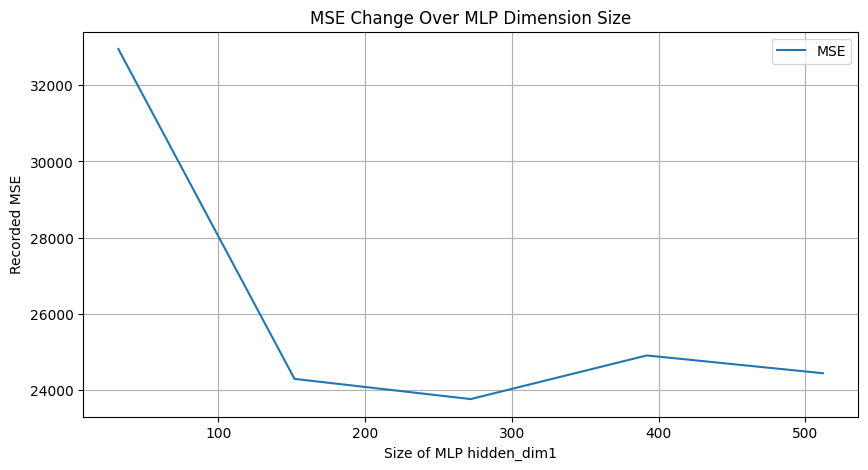

In [ ]:
#Part 3.2: MSE Change Over Complexity

NN_MSE = [24443.767,
          24910.029,
          23765.769,
          24295.449,
          32943.70
]


# Create the MSE Plot
plt.figure(figsize=(10, 5))
x = np.linspace(512, 32, num=5)  # X-axis values

# Plot each line
plt.plot(x, NN_MSE, label="MSE")


#ALSO plot the MSE per run on another graph, and R2 per run on yet another

# Add labels, title, and legend
plt.xlabel('Size of MLP hidden_dim1')
plt.ylabel('Recorded MSE')
plt.title('MSE Change Over MLP Dimension Size')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

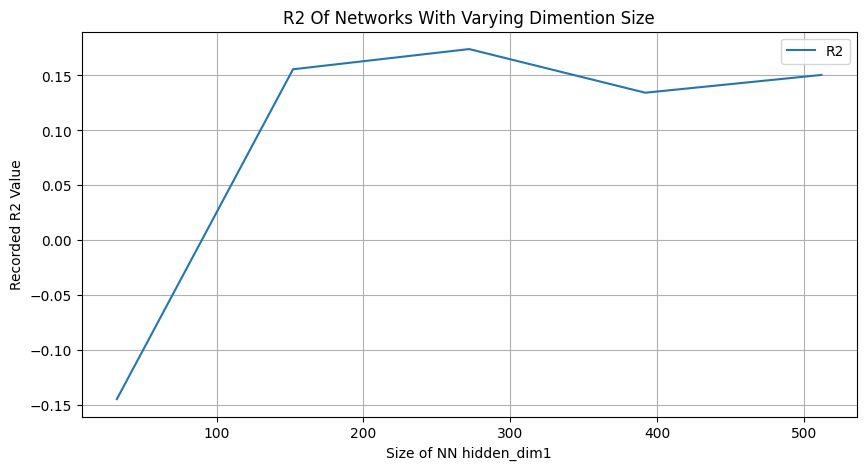

In [ ]:
#Part 3.3: R2 Change Over Complexity

NN_RSQ = [0.15050603620997416,
          0.1343021030912277,
          0.17406854464548083,
          0.15566052245301976,
          -0.14489202671247736
]


# Create the MSE Plot
plt.figure(figsize=(10, 5))
x = np.linspace(512, 32, num=5)  # X-axis values

# Plot each line
plt.plot(x, NN_RSQ, label="R2")


#ALSO plot the MSE per run on another graph, and R2 per run on yet another

# Add labels, title, and legend
plt.xlabel('Size of NN hidden_dim1')
plt.ylabel('Recorded R2 Value')
plt.title('R2 Of Networks With Varying Dimention Size')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

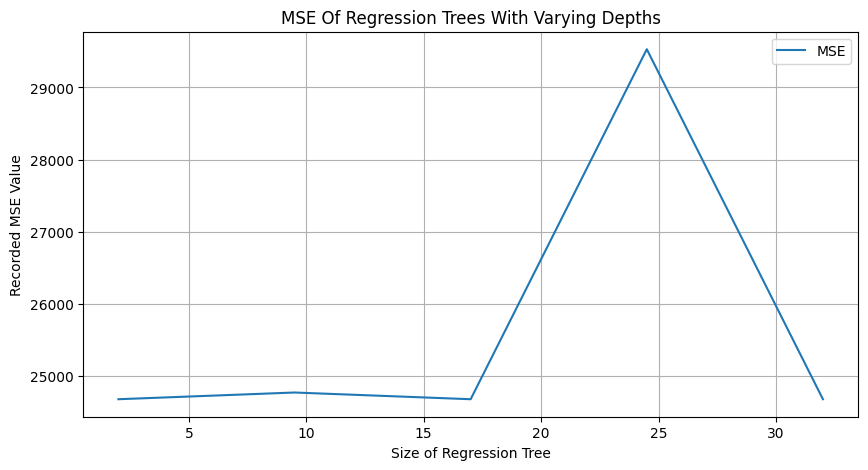

'ENDING DATA\nDEPTH ::          R2         ::     MSE\n2     :: 0.14239199126043334 :: 24677.24551073914\n4     :: 0.13915859122635543 :: 24770.284994585196\n8     :: 0.14239199126043334 :: 24677.24551073914\n16    :: 0.026224523862145466:: 29529.10218469975\n32    :: 0.14239199126043334 :: 24677.24551073914\n'

In [ ]:
#Part 3.4: MSE Change Over Complexity

Tree_MSE = [24677.24551073914,
          24770.284994585196,
          24677.24551073914,
          29529.10218469975,
          24677.24551073914
]


# Create the MSE Plot
plt.figure(figsize=(10, 5))
x = np.linspace(2, 32, num=5)  # X-axis values

# Plot each line
plt.plot(x, Tree_MSE, label="MSE")


#ALSO plot the MSE per run on another graph, and R2 per run on yet another

# Add labels, title, and legend
plt.xlabel('Size of Regression Tree')
plt.ylabel('Recorded MSE Value')
plt.title('MSE Of Regression Trees With Varying Depths')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

"""ENDING DATA
DEPTH ::          R2         ::     MSE
2     :: 0.14239199126043334 :: 24677.24551073914
4     :: 0.13915859122635543 :: 24770.284994585196
8     :: 0.14239199126043334 :: 24677.24551073914
16    :: 0.026224523862145466:: 29529.10218469975
32    :: 0.14239199126043334 :: 24677.24551073914
"""

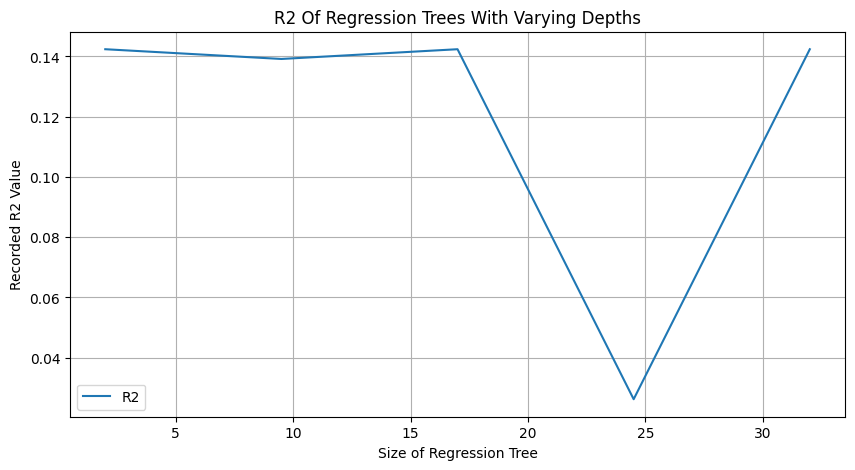

'ENDING DATA\nDEPTH ::          R2         ::     MSE\n2     :: 0.14239199126043334 :: 24677.24551073914\n4     :: 0.13915859122635543 :: 24770.284994585196\n8     :: 0.14239199126043334 :: 24677.24551073914\n16    :: 0.026224523862145466:: 29529.10218469975\n32    :: 0.14239199126043334 :: 24677.24551073914\n'

In [ ]:
#Part 3.5: MSE Change Over Complexity

Tree_MSE = [0.14239199126043334,
          0.1391585912263554,
          0.1423919912604333,
          0.026224523862145466,
          0.14239199126043334
]


# Create the MSE Plot
plt.figure(figsize=(10, 5))
x = np.linspace(2, 32, num=5)  # X-axis values

# Plot each line
plt.plot(x, Tree_MSE, label="R2")


#ALSO plot the MSE per run on another graph, and R2 per run on yet another

# Add labels, title, and legend
plt.xlabel('Size of Regression Tree')
plt.ylabel('Recorded R2 Value')
plt.title('R2 Of Regression Trees With Varying Depths')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

"""ENDING DATA
DEPTH ::          R2         ::     MSE
2     :: 0.14239199126043334 :: 24677.24551073914
4     :: 0.13915859122635543 :: 24770.284994585196
8     :: 0.14239199126043334 :: 24677.24551073914
16    :: 0.026224523862145466:: 29529.10218469975
32    :: 0.14239199126043334 :: 24677.24551073914
"""